In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import time
import datetime
import warnings

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### Data Cleaning & Preprocessing

In [41]:
def fill_na(df, columns):
    """
    Fill missing values in the specified columns of a DataFrame.

    For categorical columns (dtype 'object'):
    - Missing values are filled with the most frequent value (mode) within each ('country', 'product_category') group.
    - If no mode is found in the group, it is filled with the overall mode of the column.

    For numerical columns:
    - Missing values are filled with the mean value within each ('country', 'product_category') group.
    - If no mean is available, it is filled with the overall mean of the column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing missing values.
    columns (list): A list of column names to process.

    Returns:
    pd.DataFrame: The DataFrame with missing values filled.
    """
    for col in columns:
        if df[col].dtype == 'object':
            mode_values = df.groupby(['country', 'product_category'])[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
            df[col] = df.apply(lambda row: mode_values.get((row['country'], row['product_category']), row[col]) if pd.isna(row[col]) else row[col], axis=1)
            df[col] = df[col].fillna(df[col].mode().iloc[0])

        else:  # Fill with mean
            mean_values = df.groupby(['country', 'product_category'])[col].mean()
            df[col] = df.apply(lambda row: mean_values.get((row['country'], row['product_category']), row[col]) 
                                if pd.isna(row[col]) else row[col], axis=1).fillna(np.mean(df[col]))

    return df

In [42]:
def wrangle(file_path = "sales_dataset.json"):
    """
    Load and preprocess a sales dataset.

    Steps:
    1. Load the dataset from a JSON file.
    2. Fix column names by replacing spaces with underscores.
    3. Replace empty strings in the 'return_reason' column with NaN.
    4. Convert 'purchase_date' to a datetime format.
    5. Fill missing values in numerical and categorical columns using group-based imputation.
    6. Convert 'return_requested' to a numeric binary format.
    7. Filter out future purchase dates.
    8. Calculate 'total_spent' as (product_price * quantity_purchased - discount_applied).

    Parameters:
    file_path (str): The file path of the JSON dataset. Defaults to "sales_dataset.json".

    Returns:
    pd.DataFrame: The cleaned and preprocessed DataFrame.
    """
    df = pd.read_json(file_path)

    # Fix the column names
    df.columns = [col.replace(' ', '_') for col in df.columns]

    df['return_reason'] = df['return_reason'].replace('', np.nan)

    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    
    cols_to_fill = df.select_dtypes("number").columns[1:].tolist() + df.select_dtypes("object").columns[4:].tolist()
    
    df = fill_na(df, cols_to_fill)

    # Convert return_requested to numeric binary values
    df['return_requested'] *= 1.0

    
    df = df[df['purchase_date'] <= datetime.datetime.now()]
    df['total_spent'] = df['product_price'] * df['quantity_purchased'] - df['discount_applied']

    return df


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17680 entries, 0 to 17679
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         17680 non-null  int64         
 1   customer_name       17680 non-null  object        
 2   age                 17680 non-null  float64       
 3   email               15907 non-null  object        
 4   country             17680 non-null  object        
 5   purchase_date       17680 non-null  datetime64[ns]
 6   product_category    17680 non-null  object        
 7   product_name        17680 non-null  object        
 8   product_price       17680 non-null  float64       
 9   quantity_purchased  17680 non-null  int64         
 10  payment_method      17680 non-null  object        
 11  discount_applied    17680 non-null  float64       
 12  return_requested    17680 non-null  float64       
 13  return_reason       17680 non-null  object        


# **Data Cleaning & Preprocessing**

## **Data Quality Report**
This report outlines the data cleaning methodology applied to the sales dataset to ensure accuracy, consistency, and completeness. The dataset was read from a JSON file and underwent various preprocessing steps, where I standardized the column names, filled missing values, and performed feature extraction.

---

## **Data Cleaning Methodology**

### **Column Name Standardization**
First, I replaced the space in the column names with underscores. This is to ensure that there is consistency in the column names. Also, as a general rule, it’s not advisable to have spaces in column names.

---

### **Handling Missing Values**
#### **NumericThe `request_reason` has missing values represented as empty strings. They were converted to nan values
- l Columns:**
- Numerical columns were filled with the **mean values grouped by 'country' and 'product_category'**.
- If missing values persisted, they were **filled with the overall mean** of the column.

The reason for this was because it’d be a lazy man’s analysis to simply fill in the missing values with the average of the dataset. Instead of doing that, I subset each column to the **‘product category’** and the **country**. This would give us more similar values with the same group of people (in this case, the country) instead of using the overall average. 

After this was done, I still had a few missing values, and for these, I filled them with the overall average because I had already taken care of most of the missing values.

#### **Categorical Columns:**
- The same approach was taken, but in this case, the missing values were **imputed with the mode** within each **'country' and 'product_category'**.
- Where no mode was found, the overall mode of the column was used as a fallback.

---

### **Data Type Conversion**
- The **'purchase_date'** column was converted to **datetime format** to facilitate date-based analysis.
- The **'return_requested'** column was transformed into a **numeric binary format (0 or 1)** to ensure proper numerical operations, so that I would be able to extract percentages from it later in the EDA stage.

---

### **Data Integrity Checks**
- Records with **purchase dates in the future were removed** to maintain dataset validity.
- Some dates were after the date of my analysis (**25/03/2025**). This could be an imputation error, but as there was no benchmark to measure this with, I had to remove those entries.

---

### **Derived Feature Creation**
- A new column, **'total_spent'**, was calculated as:



### Exploratory Data Analysis

In [5]:
df.describe().drop(columns = ['customer_id', 'purchase_date', 'return_requested'])

,age,product_price,quantity_purchased,discount_applied,repeat_purchase,purchase_amount,total_spent
count,17680.00,17680.00,17680.00,17680.00,17680.00,17680.00,17680.00
mean,41.70,254.53,2.50,0.15,0.17,540.75,636.75
min,18.00,10.01,1.00,0.00,0.00,7.07,9.72
25%,29.93,131.75,1.00,0.08,0.00,211.46,253.12
50%,41.82,254.14,3.00,0.15,0.00,417.68,485.92
75%,53.52,377.02,4.00,0.22,0.00,792.35,932.93
max,65.00,499.98,4.00,0.30,1.00,1975.76,1999.61
std,13.53,141.94,1.12,0.08,0.38,415.41,482.91


**Key Observations**
- Age Distribution: Customers' ages range from 18 to 65 years, with an average of 41.7 years.
- Product Price: Prices vary from $10.01 to $499.98, with a mean of $254.53.

**Purchase Behavior:**
- The average quantity purchased is 2.5 units, with a max of 4 units.
- Discounts range from 0% to 30%, with an average of 15%.
- Repeat purchases are low, with only 17% of customers making repeat purchases.

**Spending Patterns:**
- The average purchase amount is $540.75, while the total spent (after discounts) averages $636.75.
- The highest recorded total spent is $1999.61.


We will not remove outliers in this dataset because the goal is to forecaset sales and all datapoints are needed

In [6]:
numeric_cols = df.select_dtypes(include=['number']).drop(columns=['customer_id', 'return_requested'], errors='ignore').columns

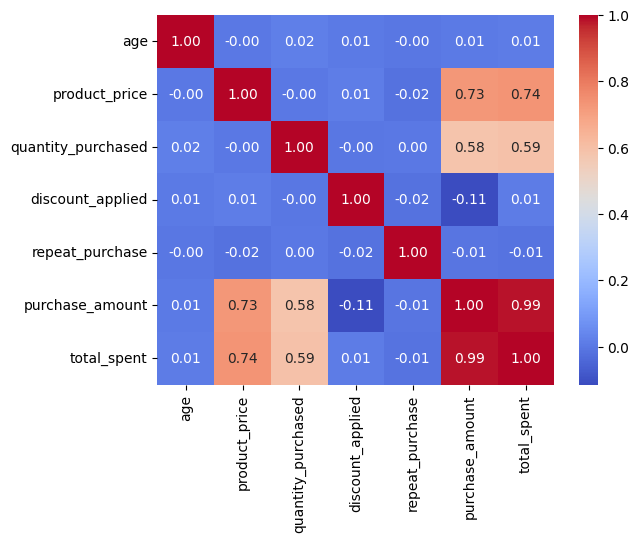

In [7]:
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm');

**Summary of Correlation Analysis**  

- **Total spending is strongly influenced by product price (0.74) and quantity purchased (0.59).** This is not out of place because high product price and quantity purchased increases total cost of purchase
- **Purchase amount and total spent are almost perfectly correlated (0.99),** confirming that total spent is derived from purchase amount.  
- **Age has no significant correlation with spending behavior, product price, or discounts.**  
- **Repeat purchases show little to no correlation with spending, suggesting that returning customers do not necessarily spend more.**  
- **Discounts have a weak negative correlation with purchase amount (-0.11), indicating that higher discounts are more common for lower purchase amounts.**  

These insights suggest that pricing and quantity drive spending, while discounts and repeat purchases have minimal impact.

**Recommendations**  

1. **Optimize Pricing:** Leverage product pricing to drive higher spending.  
2. **Encourage Bulk Purchases:** Offer discounts for larger quantities to boost revenue.  
3. **Refine Discount Strategy:** Apply discounts to high-value purchases rather than low-value ones.  
4. **Improve Customer Retention:** Introduce loyalty programs to increase repeat purchases.  
5. **Focus on Behavior-Based Marketing:** Target customers based on purchase habits, not age.

In [8]:
# Find top 10 product with highest number of sales
top_products = df.groupby('product_name')['quantity_purchased'].sum().sort_values(ascending=False).head(10)
print(top_products)

product_name
T-Shirt          1469
Tennis Racket    1360
Running Shoes    1355
Serum            1347
Blender          1341
Microwave        1337
Smartphone       1326
Bicycle          1321
Coffee Maker     1311
Jacket           1311
Name: quantity_purchased, dtype: int64


**Comment: These products are the most popular, indicating strong customer demand across **fashion, sports, beauty, home appliances, and electronics**.

In [9]:
# Find top 10 product with highest revenue
top_revenue_products = df.groupby('product_name')['total_spent'].sum().sort_values(ascending=False).head(10)
print(top_revenue_products)

product_name
Tennis Racket   359446.96
T-Shirt         353246.39
Smartphone      350794.40
Serum           345344.60
Blender         340980.69
Microwave       339162.46
Running Shoes   337748.42
Shoes           334637.80
Air Fryer       333204.44
Coffee Maker    330462.08
Name: total_spent, dtype: float64


**Comment: These products generate the highest revenue, highlighting sports equipment, apparel, beauty, and home appliances as key revenue drivers.**

In [10]:
# Calculate total spending for each customer segment and sort in descending order  
segment_spending = df.groupby('customer_segment')['total_spent'].sum().sort_values(ascending=False)
segment_spending

customer_segment
Loyal Customer   2362872.41
New Customer     2242818.11
VIP              2233620.41
Premium          2228578.89
Standard         2189791.87
Name: total_spent, dtype: float64

**Comment:**
There isn't much of a difference in the spending pattern but to retain customers, the company can give targeted rewards. Instances are
- Reward Loyal Customers with discounts and VIP perks.
- Convert New Customers through personalized onboarding and promotions.
- Engage VIP/Premium Customers with exclusive deals.
- Upsell to Standard Customers with targeted offers

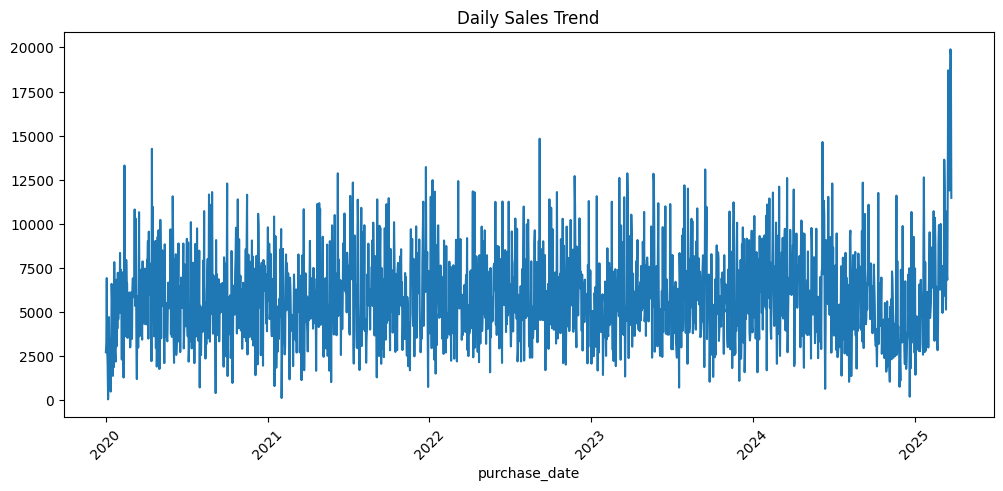

In [11]:
# Visualize the trend in daily sales (total)
daily_sales = df.groupby(df['purchase_date'].dt.date)['total_spent'].sum()

plt.figure(figsize=(12,5))
sns.lineplot(x=daily_sales.index, y=daily_sales.values)
plt.xticks(rotation=45)
plt.title("Daily Sales Trend")
plt.show()

**Sales Trend Analysis**  
- **Steady Growth:** Sales have increased over time, with fluctuations.  
- **Seasonal Spikes:** Noticeable peaks suggest periodic high demand.  
- **Recent Surge:** A sharp rise in 2025 indicates a strong upward trend. 

In [12]:
# Calculate rate at which products are returned
return_rates = df.groupby('product_category')['return_requested'].mean().sort_values(ascending=False)

In [13]:
def create_visual(df, to_group = 'country', group_col = 'return_requested', top_n = None, threshold = None, title = []):
    """
    Create an enhanced horizontal bar plot of return rates.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing country and return information
    top_n : int, optional (default=30)
        Number of top countries to display
    threshold : float, optional
        Minimum return rate to include in the visualization
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created visualization figure
    """
    # Calculate return rates
    return_rates = df.groupby(to_group)[group_col].mean().sort_values(ascending=False)
    
    # Apply threshold if specified
    if threshold is not None:
        return_rates = return_rates[return_rates <= threshold]
    
    # Select top N countries
    return_rates = return_rates.head(top_n)
    
    # Create the figure with improved resolution
    plt.figure(figsize=(14, 8), dpi=100)
    
    # Create color palette with gradient
    colors = plt.cm.YlOrRd(np.linspace(0.3, 1, len(return_rates)))
    
    # Create horizontal bar plot
    ax = sns.barplot(
        y = return_rates.index, 
        x = return_rates.values, 
        orient = 'h', 
        palette = colors
    )
    
    # Customize plot aesthetics
    plt.title(f"{title[0]}", fontsize=16,  fontweight='bold',  pad=20)
    plt.xlabel(f"{title[1]}", fontsize=12, fontweight='bold')
    plt.ylabel(f"{title[2]}", fontsize=12, fontweight='bold')
    
    # Add value labels to the end of each bar
    for i, v in enumerate(return_rates.values):
        ax.text(
            v, 
            i, 
            f' {v:.2%}', 
            va='center', 
            fontweight='bold',
            color='darkslategray'  # Corrected color name
        )
    
    # Improve layout
    plt.tight_layout()
    
    # Add grid for better readability
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Add a subtle background color
    ax.set_facecolor('#f0f0f0')
    
    # Show the plot
    plt.show();
    
    return plt.gcf();

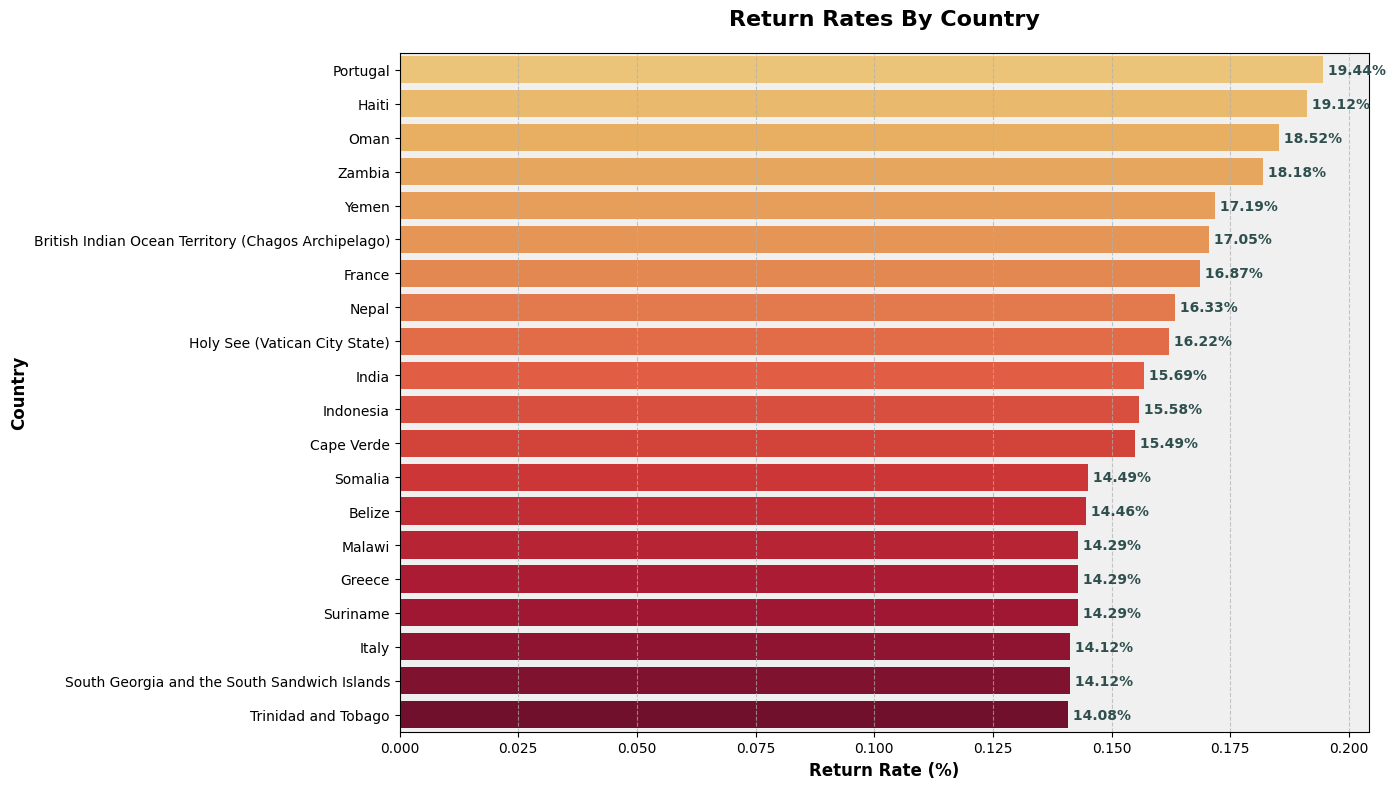

<Figure size 640x480 with 0 Axes>

In [14]:
create_visual(df, to_group = 'country', 
              group_col = 'return_requested', 
              top_n = 20, threshold = 1, 
              title = ["Return Rates By Country", "Return Rate (%)", "Country"]
             );

**Comment:**
- High Returns: Portugal, Haiti, and Oman have the highest return rates.
- Global Impact: Multiple countries show return rates above 14%, indicating widespread return concerns.
- Potential Issues: Product quality, incorrect orders, or customer expectations may be driving returns.

In [15]:
#From the visual
top_countries = ["Portugal", "Haiti", "Oman", "Zambia", "Yemen", 
                 "British Indian Ocean Territory (Chagos Archipelago)", 
                 "France", "Nepal", "Holy See (Vatican City State)", "India"]

return_crosstab = pd.crosstab(df['country'], df['return_reason'], normalize='index') * 100

return_crosstab['Total Returns'] = return_crosstab.sum(axis=1)
return_crosstab = return_crosstab.loc[top_countries]
return_crosstab = return_crosstab.sort_values(by='Total Returns', ascending=False)
return_crosstab.drop(columns = ['Total Returns'], inplace = True)

return_crosstab

return_reason,Arrived Late,Changed Mind,Damaged in Shipping,Defective Product,Not as Described,Wrong Size
country,,,,,,
India,52.94,43.14,0.00,0.00,0.00,3.92
Portugal,68.06,1.39,0.00,16.67,12.50,1.39
Haiti,7.35,76.47,10.29,0.00,1.47,4.41
Oman,42.59,11.11,0.00,16.67,16.67,12.96
Zambia,13.64,10.61,37.88,1.52,34.85,1.52
Yemen,39.06,53.12,0.00,3.12,1.56,3.12
British Indian Ocean Territory (Chagos Archipelago),20.45,40.91,2.27,1.14,23.86,11.36
France,30.12,8.43,36.14,16.87,0.00,8.43
Nepal,44.90,14.29,16.33,12.24,2.04,10.20


**Comment:**
- Late arrivals are a top reason across multiple countries.
- Changing minds is a major issue in Haiti and Yemen.
- Damaged products are a significant issue in Zambia and France.
- Defective items and inaccurate descriptions cause noticeable returns in some regions.

In [16]:
# Let's check the country with the highest number of customers
customer_count = df.groupby('country')['customer_id'].nunique()
customer_count.sort_values(ascending = False).head()

country
Congo       122
Korea       115
Gabon        80
Romania      79
Colombia     79
Name: customer_id, dtype: int64

In [22]:
customer_count = df.groupby('country')['customer_id'].nunique()
return_rate = df.groupby('country')['return_requested'].mean()
avg_purchase = df.groupby('country')['total_spent'].mean()

# Combine into a single DataFrame
country_return_rates = pd.DataFrame({'customer_count': customer_count, 'return_rate': return_rate, 'avg_purchase' : avg_purchase}).sort_values(by='customer_count', ascending=False)
country_return_rates = country_return_rates.loc[top_countries]
country_return_rates.head()

,customer_count,return_rate,avg_purchase
country,,,
Portugal,66,0.19,701.04
Haiti,62,0.19,644.14
Oman,47,0.19,690.71
Zambia,58,0.18,660.87
Yemen,57,0.17,751.99


- These countries have many customers considering that the country with the highest number of customer (Congo) has just 122. So, their concerns other than `Changed mind`should be treated.
- Also, the reason why people changed their mind after purchasing a product should be investigated.

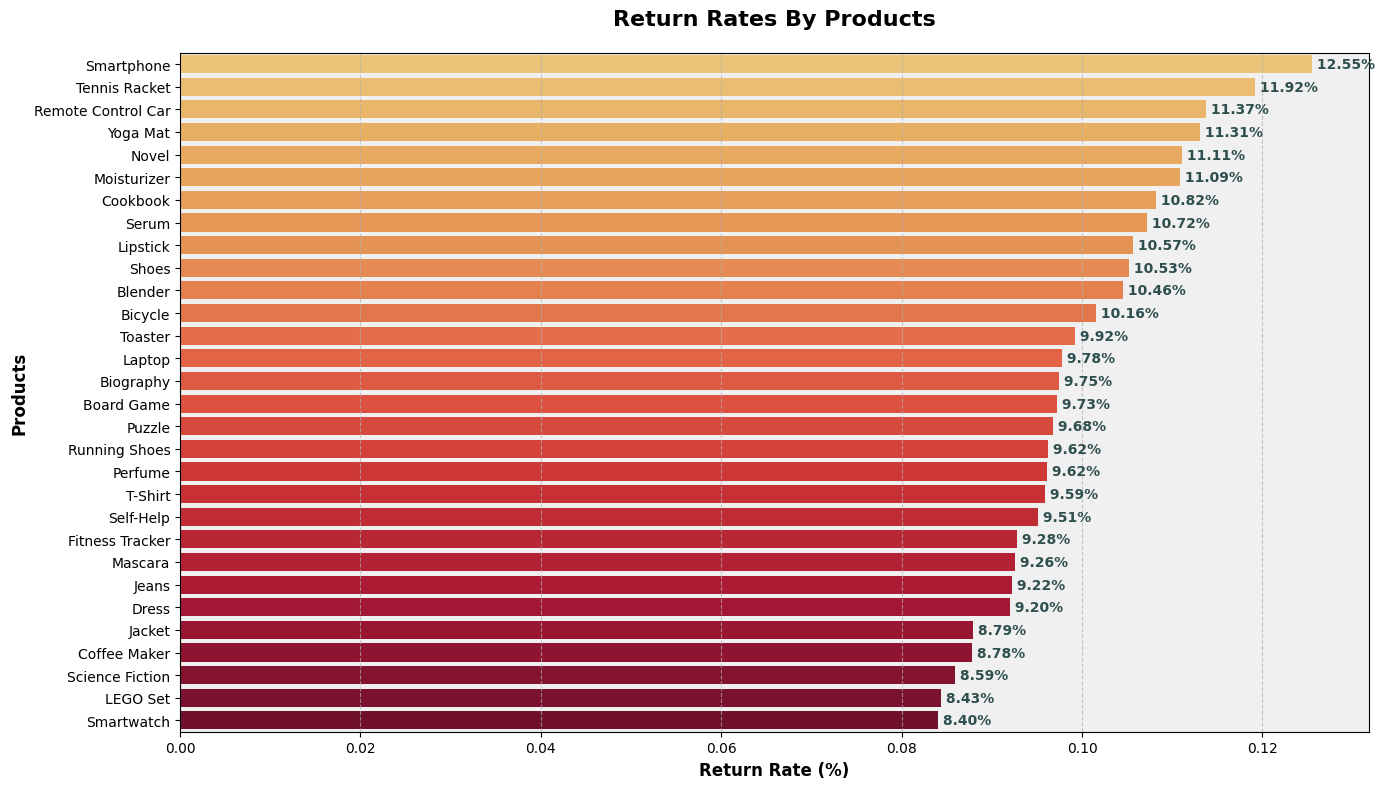

<Figure size 640x480 with 0 Axes>

In [18]:
create_visual(df, to_group = 'product_name', 
              group_col = 'return_requested', 
              top_n = 30, threshold = 0.85, 
              title = ["Return Rates By Products", "Return Rate (%)", "Products"]
             );

**Comment:**
- **Smartphones have the highest return rate (12.55%)**, likely due to defects or unmet expectations.  
- **Sports & fitness items (Tennis Racket, Yoga Mat, Running Shoes) see high returns**, possibly due to sizing issues.  
- **Electronics & wearables (Smartwatch, Fitness Tracker) also have notable returns**, likely from functionality concerns.  
- **Beauty & fashion products (Lipstick, Moisturizer, T-Shirts, Jeans) face returns**, mostly due to shade mismatches or sizing.  
- **Books and toys (Novels, Board Games, LEGO Sets) have moderate return rates**, possibly due to damage or dissatisfaction.

In [19]:
return_crosstab = pd.crosstab(df['product_name'], df['return_reason'], normalize='index') * 100

return_crosstab['Total Returns'] = return_crosstab.sum(axis=1)
return_crosstab = return_crosstab.sort_values(by='Total Returns', ascending=False)
return_crosstab.drop(columns = ['Total Returns'], inplace = True)
return_crosstab.head()

return_reason,Arrived Late,Changed Mind,Damaged in Shipping,Defective Product,Not as Described,Wrong Size
product_name,,,,,,
Air Fryer,44.27,10.26,11.07,12.27,12.27,9.86
Microwave,53.51,8.92,9.30,7.40,12.90,7.97
Coffee Maker,53.24,11.45,8.21,9.73,9.73,7.63
Mascara,49.59,16.26,13.99,7.82,8.02,4.32
Cookbook,47.76,16.12,8.98,9.80,9.80,7.55


**Comment:**
- **Late arrivals dominate returns across all products**, especially for appliances.  
- **Beauty products like mascara** have higher returns due to damage during shipping.  
- **Books (cookbooks) see a high rate of "changing mind" returns**

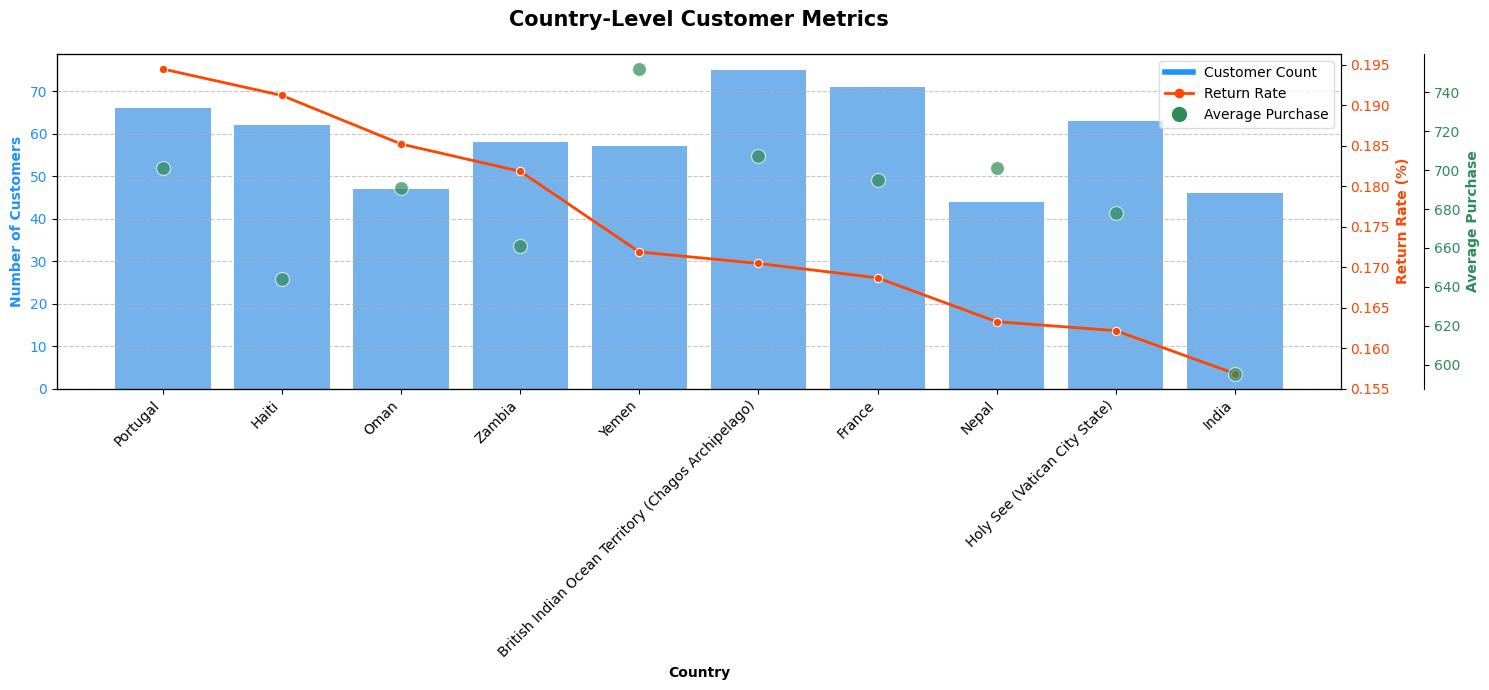

In [23]:
def create_country_stats_plot(country_stats):
    """
    Create a comprehensive visualization of country-level statistics
    with improved readability and design.
    
    Parameters:
    -----------
    country_stats : pandas.DataFrame
        DataFrame containing columns: 
        - customer_count
        - return_rate
        - avg_purchase
    """
    # Create figure with increased resolution and better aspect ratio
    plt.figure(figsize=(15, 7), dpi=100)
    
    # Create grid for better layout
    gs = plt.GridSpec(1, 1)
    ax = plt.subplot(gs[0, 0])
    
    # Color palette for better aesthetics
    colors = {
        'customer_count': '#1E90FF',  # Dodger Blue
        'return_rate': '#FF4500',     # Orange Red
        'avg_purchase': '#2E8B57'     # Sea Green
    }
    
    # Bar plot for customer count
    bars = sns.barplot(
        x=country_stats.index, 
        y=country_stats['customer_count'], 
        color=colors['customer_count'], 
        alpha=0.7,
        ax=ax
    )
    
    # Customize bar plot
    ax.set_xlabel("Country", fontweight='bold')
    ax.set_ylabel("Number of Customers", color=colors['customer_count'], fontweight='bold')
    ax.tick_params(axis='y', labelcolor=colors['customer_count'])
    
    # Rotate and align the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Create twin axes for return rate
    ax2 = ax.twinx()
    sns.lineplot(
        x=range(len(country_stats.index)), 
        y=country_stats['return_rate'], 
        color=colors['return_rate'], 
        marker='o', 
        linewidth=2,
        ax=ax2
    )
    ax2.set_ylabel("Return Rate (%)", color=colors['return_rate'], fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=colors['return_rate'])
    
    # Create a third twin axis for average purchase
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
    sns.scatterplot(
        x=range(len(country_stats.index)), 
        y=country_stats['avg_purchase'], 
        color=colors['avg_purchase'], 
        s=100,  # Increase marker size
        alpha=0.7,
        ax=ax3
    )
    ax3.set_ylabel("Average Purchase", color=colors['avg_purchase'], fontweight='bold')
    ax3.tick_params(axis='y', labelcolor=colors['avg_purchase'])
    
    # Add title with improved formatting
    plt.title(
        "Country-Level Customer Metrics", 
        fontsize=15, 
        fontweight='bold', 
        pad=20
    )
    
    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Improve overall layout
    plt.tight_layout()
    
    # Create custom legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color=colors['customer_count'], lw=4),
        Line2D([0], [0], color=colors['return_rate'], lw=2, marker='o'),
        Line2D([0], [0], color=colors['avg_purchase'], marker='o', linestyle='None', markersize=10)
    ]
    ax.legend(
        custom_lines, 
        ['Customer Count', 'Return Rate', 'Average Purchase'], 
        loc='best',
        framealpha=0.7
    )
    
    plt.show()

country_stats = country_return_rates.head(30)
create_country_stats_plot(country_stats)

**Comment:**
- A **high number of customers does not always mean a high return rate** (e.g., Korea has many customers but a moderate return rate).  
- Some countries have a **high return rate despite fewer customers** (e.g., Iceland).  
- Countries with **higher purchase values tend to have fluctuating return rates**, suggesting that product pricing or quality may influence returns.  

### **Executive Summary: Customer Return Trends and Business Insights**  
#### **Key Takeaways from Data Analysis**  
Our analysis of customer returns and purchasing behavior across different countries and product categories has revealed critical insights that can guide business decisions.  

1. **Return Reasons Vary by Country & Product**  
   - "Arrived Late" and "Changed Mind" are the top reasons for returns across most regions, but some countries have distinct return trends.  
   - Products like **Mascara and Cookbooks** have higher returns due to customer dissatisfaction with descriptions and defects.  

2. **Correlation Analysis Highlights**  
   - **High return rates** are associated with higher purchase frequency, suggesting that repeat buyers are more likely to return items.  
   - **Order size and return likelihood**: Larger orders tend to have higher return rates, possibly due to bulk purchases leading to more dissatisfaction.  
   - **Customer behavior insight**: Countries with high return rates also show higher average purchase values, indicating that more expensive items might face quality concerns.  

3. **Country-Level Customer Metrics**  
   - Countries like Switzerland, South Georgia have **higher return rates** and lower average purchases, meaning returns may discourage repeat buying.  
   - **Belize, France, Italy, and British Indian Ocean** show high return rates but also a strong customer base, making them key markets for improvement.  

---

### **Actionable Business Recommendations**  

#### **Marketing Strategy**  
- **Targeted Campaigns**: Use return data to segment customers and tailor communication. Offer personalized discounts or loyalty incentives for high-return customers to improve retention.  
- **Set Clear Expectations**: Highlight accurate product descriptions, especially for high-return categories like cosmetics and books.  
- **Country-Specific Messaging**: Adapt marketing messages based on regional return trends to manage expectations and reduce dissatisfaction.  

#### **Sales Strategy**  
- **Optimize Pricing & Promotions**: Products with high return rates should undergo price testing or bundling strategies to enhance value perception.  
- **Improve Delivery & Logistics**: Since "Arrived Late" is a leading cause of returns, strengthening shipping partnerships in high-return regions can mitigate this issue.  
- **Customer Education**: Provide detailed buying guides and customer reviews to help reduce impulse purchases that lead to "Changed Mind" returns.  

#### **Product Strategy**  
- **Quality Control Improvements**: Categories like **cosmetics and electronics** should have enhanced quality checks before shipping.  
- **Improve Sizing & Product Fit Guidance**: Implement detailed sizing guides and AR (Augmented Reality) previews for fashion-related items to reduce returns due to incorrect sizes.  
- **Monitor High-Value Purchases**: Products with **high return rates and high purchase values** should be reviewed for potential defects or misleading descriptions.  

By implementing these strategies, the business can reduce return rates, enhance customer satisfaction, and optimize revenue.  

### Predictive Modelling

In [24]:
def aggregate_sales(df, freq='D'):
    """
    Aggregate sales data by specified time frequency
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original sales dataset
    freq : str, optional (default='D')
        Frequency of aggregation
        'D' - Daily
        'W' - Weekly
        'M' - Monthly
    
    Returns:
    --------
    pandas.DataFrame with aggregated sales metrics
    """
    # Group by specified time frequency
    time_series = df.groupby(pd.Grouper(key = 'purchase_date', freq=freq)).agg({
        'purchase_amount': 'sum',
        'customer_id': 'count',
        'product_price': 'mean',
        'product_name': 'nunique',
        'quantity_purchased': 'mean',
        'discount_applied': 'sum',
        'return_requested': 'mean'
    }).reset_index()
    
    # Rename columns for clarity
    time_series.columns = ['purchase_date', 'total_sales', 'num_transactions', 'avg_product_price',  'unique_products',  'avg_quantity',  'total_discount', 'return_rate']
    
    return time_series

daily_sales = aggregate_sales(df, freq='D')
daily_sales.set_index('purchase_date', inplace=True)

In [25]:
# Calculate the change in sales daily (logarithm change)
daily_sales.sort_index(ascending = False, inplace = True) #Date has to be in descending order
log_return = np.log(daily_sales['total_sales']) - np.log(daily_sales['total_sales'].shift(1))
daily_sales['return'] = log_return

In [26]:
daily_sales.sort_index(ascending = True, inplace = True) #Return to its original state
daily_sales.dropna(inplace = True)
daily_sales.head()

,total_sales,num_transactions,avg_product_price,unique_products,avg_quantity,total_discount,return_rate,return
purchase_date,,,,,,,,
2020-01-01,2318.50,4,309.25,4,2.25,0.43,0.00,-0.12
2020-01-02,2621.96,7,300.27,7,1.71,1.31,0.00,-0.80
2020-01-03,5839.44,9,299.94,7,2.67,1.56,0.00,0.83
2020-01-04,2541.10,4,363.91,4,2.25,0.43,0.00,0.39
2020-01-05,1719.77,4,233.38,4,2.25,0.61,0.00,3.76


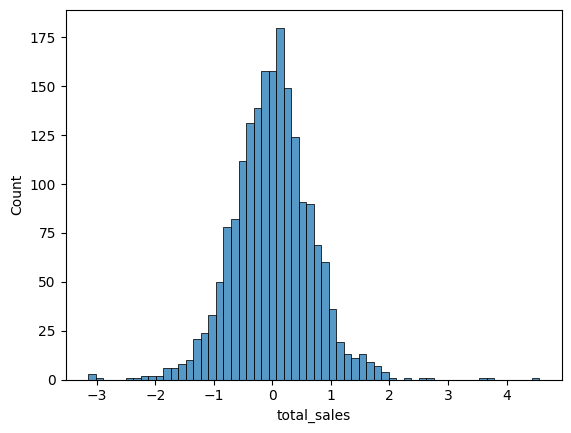

In [27]:
#Visualize return
sns.histplot(log_return);

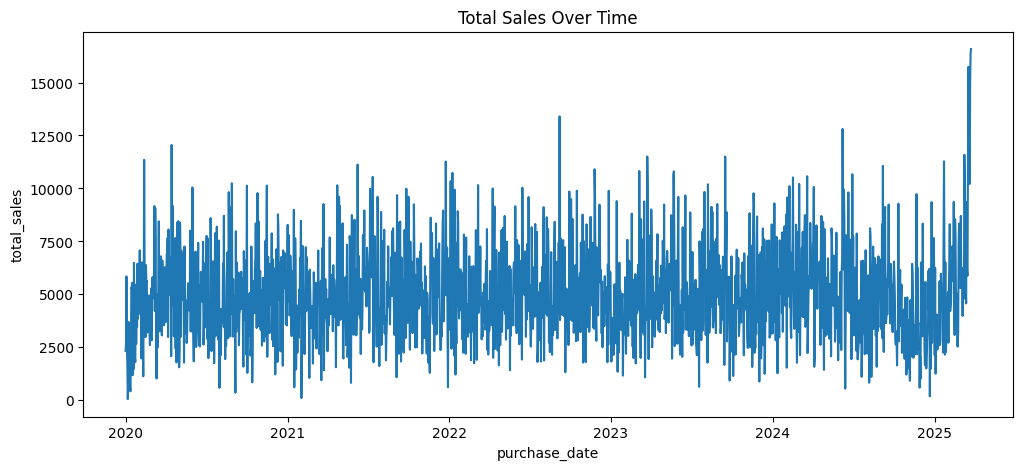

In [28]:
# Visualize total_sales trend
pred_col = 'total_sales' #total_sales
plt.figure(figsize=(12, 5))
sns.lineplot(data = daily_sales, x = daily_sales.index, y = pred_col)
plt.title("Total Sales Over Time")
plt.show();

In [29]:
# Define exogenous variables
exog_vars = ['num_transactions', 'avg_product_price', 'unique_products', 'avg_quantity', 'total_discount', 'return_rate']
train_size = int(0.7 * len(daily_sales))
train, test = daily_sales.iloc[:train_size], daily_sales.iloc[train_size:]

In [30]:
# SARIMAX Model
sarimax_model = SARIMAX(train[pred_col], exog=train[exog_vars], order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_result = sarimax_model.fit()
forecast_sarimax = sarimax_result.predict(start=len(train), end=len(daily_sales)-1, exog=test[exog_vars])

In [31]:
# Evaluate performance
mae = mean_absolute_error(test[pred_col], forecast_sarimax)
rmse = np.sqrt(mean_squared_error(test[pred_col], forecast_sarimax))

print(f"SARIMAX MAE: {mae}, RMSE: {rmse}")

SARIMAX MAE: 467.93306912526464, RMSE: 628.9977113076804


In [32]:
#Prophet Model
# Prepare dataframe for Prophet
exog_vars = ['num_transactions', 'avg_product_price', 'unique_products', 'avg_quantity', 'total_discount', 'return_rate']
df_prophet = daily_sales[[pred_col] + exog_vars].reset_index()
df_prophet = df_prophet.rename(columns={'purchase_date': 'ds', pred_col: 'y'})

# Initialize and fit Prophet with regressors
prophet = Prophet()
for var in exog_vars:
    prophet.add_regressor(var)

prophet.fit(df_prophet)

# Create future dataframe
future = prophet.make_future_dataframe(periods=len(test))

future = future.merge(daily_sales[exog_vars], left_on='ds', right_on = daily_sales.index, how='left')
# Merge future regressors
future[exog_vars] = future[exog_vars].fillna(method='ffill').fillna(0)

# Forecast
forecast = prophet.predict(future)

# Align predictions with test data
prophet_predictions = forecast.set_index('ds').loc[test.index, 'yhat']

12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Evaluate Performance
mae = mean_absolute_error(test[pred_col], prophet_predictions)
rmse = np.sqrt(mean_squared_error(test[pred_col], prophet_predictions))

print(f"Prophet MAE: {mae}, RMSE: {rmse}")

Prophet MAE: 461.8305471910404, RMSE: 619.9997395937763


In [36]:
# XGBoost Model
X = daily_sales[exog_vars]
y = daily_sales[pred_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

#Evaluate Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb}, RMSE: {rmse_xgb}")

XGBoost MAE: 424.46132891136455, RMSE: 472043.0461023413


In [37]:
# Compare Results Visually
predictions = pd.DataFrame({
    'actual': test[pred_col],
    'prophet_predictions': prophet_predictions,
    'XGBoost_predictions': y_pred_xgb,
    'SARIMAX': forecast_sarimax
}).set_index(test.index)

predictions.sort_index(ascending = False)

,actual,prophet_predictions,XGBoost_predictions,SARIMAX
purchase_date,,,,
2025-03-24,16584.45,15886.63,10397.41,15641.06
2025-03-23,16380.98,14441.38,10475.55,14185.76
2025-03-22,14968.61,13609.63,10026.01,13439.85
2025-03-21,10208.84,11641.47,9444.20,11508.72
2025-03-20,11990.84,10790.08,10697.33,10769.78
...,...,...,...,...
2023-09-03,5074.82,4635.48,3924.35,4432.69
2023-09-02,4496.52,4661.72,4528.97,4468.64
2023-09-01,6855.61,6936.82,7071.28,6803.96


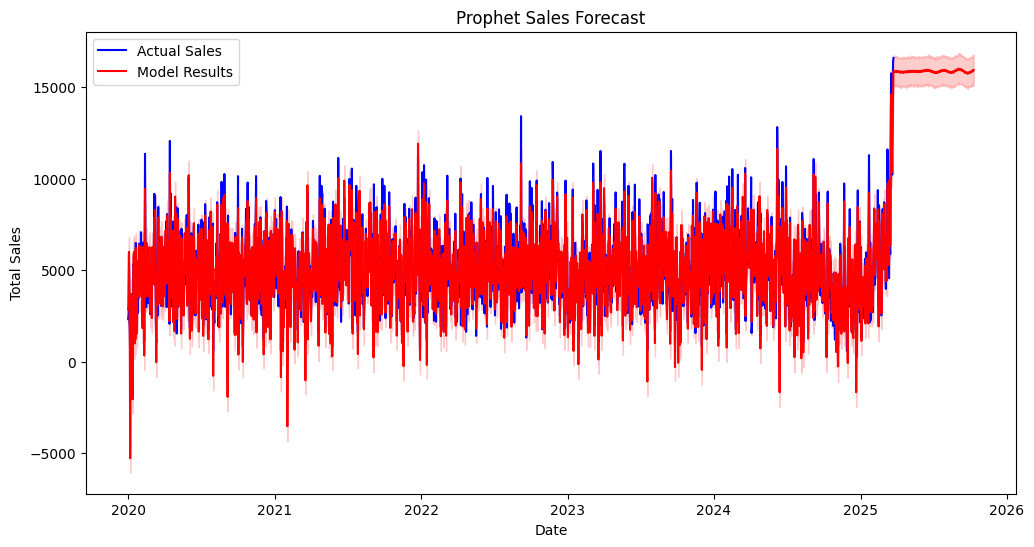

In [47]:
# Make Predictions using Propher algorithm
future_periods = 200
future = prophet.make_future_dataframe(periods=future_periods)

# Merge future regressors
future = future.merge(daily_sales[exog_vars], left_on='ds', right_on='purchase_date', how='left')
future[exog_vars] = future[exog_vars].fillna(method='ffill').fillna(0)

# Forecast
forecast = prophet.predict(future)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales[pred_col], label='Actual Sales', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Model Results', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Prophet Sales Forecast")
plt.legend()
plt.show()

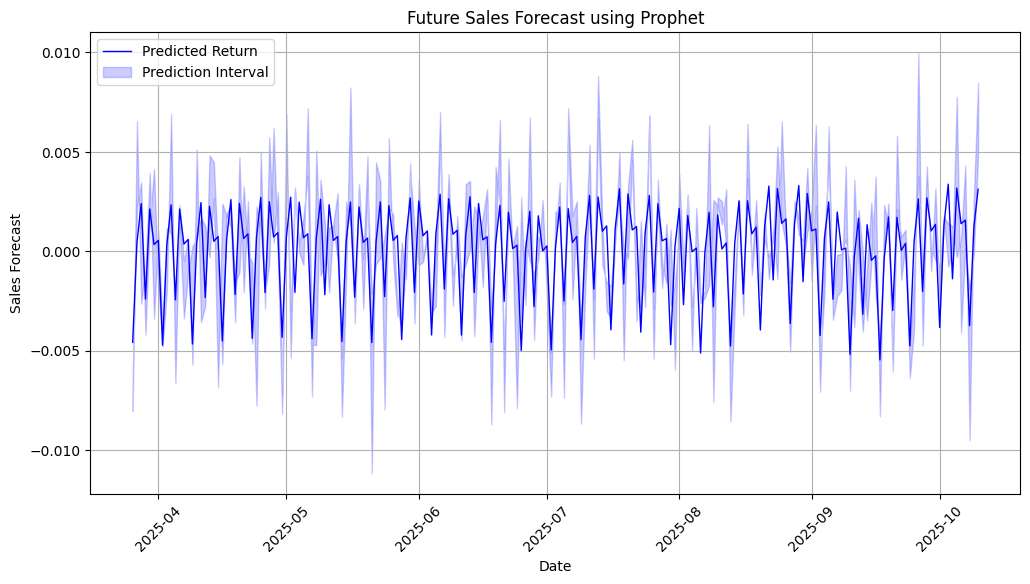

In [48]:
# Filter for future forecasts only
future_forecast = forecast[forecast['ds'] > test.index.max()]

future_forecast['yhat_lower'] = np.log(future_forecast['yhat_lower']) - np.log(future_forecast['yhat_lower'].shift(1))
future_forecast['yhat'] = np.log(future_forecast['yhat']) - np.log(future_forecast['yhat'].shift(1))
future_forecast['yhat_upper'] = np.log(future_forecast['yhat_upper']) - np.log(future_forecast['yhat_upper'].shift(1))

plt.figure(figsize=(12, 6))
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted Return', color='blue', linewidth = 1)
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Prediction Interval')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Sales Forecast')
plt.title('Future Sales Forecast using Prophet')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show();

## **Sales Forecast Modeling**  

### **Objective**  
The goal of this analysis is to **forecast daily sales** using time series models. I aggregated sales data to **daily, weekly, and monthly levels**, providing flexibility for different forecasting needs.  

### **Data Exploration**  
- Calculated and visualized **log returns**, which appeared **right-skewed** (no further statistical tests were performed).  
- Selected models that perform well with skewed returns:  
  - **Prophet**  
  - **SARIMAX**  
  - **XGBoost**  

### **Model Performance**  

| Model   | MAE (Mean Absolute Error) | RMSE (Root Mean Squared Error) |
|---------|---------------------------|--------------------------------|
| **SARIMAX** | **467.93** | **628.99** |
| **Prophet** | **461.83** | **619.99** |
| **XGBoost** | **424.46** | **472043.05** |

### **Model Selection & Insights**  
- **Prophet was chosen** because it had the lowest RMSE, making it more sensitive to outliers.  
- **SARIMAX performed similarly to Prophet**, making it a viable alternative.  
- **XGBoost had the lowest MAE but an extremely high RMSE**, indicating high variance and poor generalization.  

### **Forecasting & Visualization**  
- Developed a **forecasting function** that outputs predicted sales along with **confidence intervals**.  
- Created a **forecast visualization chart** to illustrate predicted trends.  

### **Next Steps & Improvements**  
- Further investigation into **log return skewness** to improve model assumptions.  
- Hyperparameter tuning for **SARIMAX and XGBoost** to enhance performance.  
- Experimenting with **alternative models like LSTMs** for potential improvements in long-term forecasting.

### Data Storytelling & Dashboard Presentation
- For this I used streamlit. The goal was to host the model online alongside the dashboard but I was running out of time.
- The link to the dashboard: https://alphaglobal-sales-forecast.streamlit.app/
